## OPD characterization with PSSN and FWHM


In [94]:
import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


In [4]:
accessPath  = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia'
dataDir = os.path.join(accessPath, 'dr2_high_full_2020_24','iter0', 'img')

The following is  usually used to compare the result of wavefront error estimation based on donut extra/intra focal images to the OPD (truth):

In [130]:
class calcMetrics():

    def loadZernikeData(self, opdZkFilePath, wfsZkFilePath):

        opdZkData = np.loadtxt(opdZkFilePath)
        wfsZkData = np.loadtxt(wfsZkFilePath)

        return opdZkData, wfsZkData


    def calcSSR(self, opdZkData, wfsZkData):

        zerDiffSqByField = np.sum((wfsZkData - opdZkData)**2, axis=1)
        zerDiffSqTotal = np.sum(zerDiffSqByField)

        return zerDiffSqByField, zerDiffSqTotal

# initialize metrics class 
calcMagMetrics = calcMetrics()

# initialize storage arrays 
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []
    
opdZkFilePath = os.path.join(dataDir, 'opd.zer.gaia')
wfsZkFilePath = os.path.join(dataDir, 'wfs.zer.gaia')
opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
opdData = opdData[:3]
wfsData = wfsData[:3]
zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))


Text(0.5, 1.0, 'Zernike Errors, GAIA DR2')

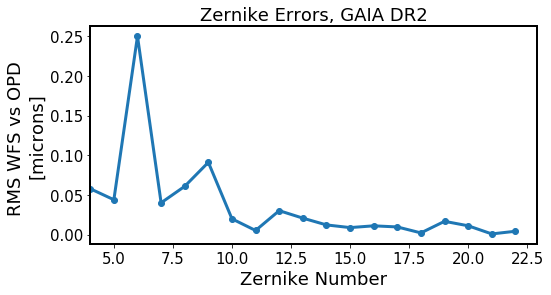

In [131]:
# and it's plotted as the rms error vs Zernike number:
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, 0]), 
         '-o', lw=3, label='')
ax.set_xlim(4.)
ax.set_xlabel('Zernike Number', size=18)
ax.set_ylabel('RMS WFS vs OPD \n[microns]', size=18)
ax.set_title('Zernike Errors, GAIA DR2', size=18)


Lets see what is contained inside each OPD file , that is later characterized by the `opd.zer.` and `PSSN.txt` files:

In [95]:
from astropy.io import fits

opdDir = dataDir
print(opdDir)

opdFile= os.path.join(opdDir, 'opd_9006000_0.fits.gz') # for the first CCD 
opd = fits.getdata(opdFile)


/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24/iter0/img


In [8]:
np.shape(opd)

(255, 255)

[ What does the opd file (for each CCD) represent ?  Why is the shape 255x255 ? ]

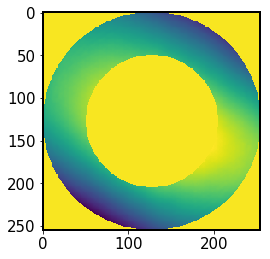

In [9]:
%matplotlib inline
plt.imshow(opd)

That's what it looks like - like one of the mirrors (?) 

Question - can we split the wfs.zer  into magnitudes   ? Answer - Not unless the sources are grouped by magnitude at the `ts_wep` stage. This capability has been introduced in `baseComcamLoop.py` https://github.com/lsst-ts/ts_phosim/blob/uw_dev/notebooks/analysis_scripts/baseComcamLoop.py  `splitWfsByMag` flag.  

The file `wfs.zer.gaia`  contains the wavefront sensing estimation in terms of Zernikes for each of the 9 field locations (for ComCam) 

The file `opd.zer.gaia` contains the OPD expressed in terms of Zernike expansion also for the 9 chosen field locations (for comcam it's the center of each CCD since we're simulating the telescope behavior - normally we'd evaluate OPD at 31 field locations that represent the full FOV of the telescope - as in Doc-17171 https://docushare.lsstcorp.org/docushare/dsweb/Get/Document-17171 )

(for this reason, when evaluating OPD for the corner sensors at 31 field locations, eg in `analysis_scripts/results_wfs/arrowStars/iter0/img`, the `opd.zer.wfs` file has 31 rows, one for each OPD location). 

**About PSSN: **

* Angeli2016 "Normalized Point Source Sensitivity for LSST" (doc-17242) : https://docushare.lsst.org/docushare/dsweb/Get/Document-17242/PSSN%20for%20LSST%20v12.pdf 
* Seo2009 Analysis of normalized point source sensitivity as a performance metric for large telescopes   https://www.osapublishing.org/ao/abstract.cfm?uri=ao-48-31-5997 
* Seo2013 Estimation of normalized point-source sensitivity of segment surface specifications for extremely large telescopes https://www.osapublishing.org/ao/abstract.cfm?uri=ao-52-18-4111 
* Xin2015 Xin, B., Angeli, G., Claver, C. “Analysis of the Effects of M1M3 Crow’s Feet” https://docushare.lsstcorp.org/docushare/dsweb/Get/Document-17171  (chapter 4 concerns PSSF) 

The PSSN given each OPD file is calculated in metr.calcPSSN() https://github.com/lsst-ts/ts_phosim/blob/9bd5bec229712c867ce174b7d437daea77dba11e/python/lsst/ts/phosim/OpdMetrology.py#L305 that calls calc_pssn() from https://github.com/lsst-ts/ts_phosim/blob/9bd5bec229712c867ce174b7d437daea77dba11e/python/lsst/ts/phosim/MetroTool.py#L8

The file `PSSN.txt` contains three lines:
    
    # The following are PSSN and FWHM (in arcsec) data. The final number is the GQ value.
    PSSN_location_1, PSSN_location_2, PSSN_location_3 , ...... , PSSN_location_N , GQ_EFF_PSSN 
    FWHM_location_1, FWHM_location_2, FWHM_location_3, ........, FWHM_location_N,  GQ_EFF_FWHM
    

Where `GQ_EFF_PSSN` is the sum(weights*PSSN_values) calculated eg. for comcam https://github.com/lsst-ts/ts_phosim/blob/9bd5bec229712c867ce174b7d437daea77dba11e/python/lsst/ts/phosim/PhosimCmpt.py#L1016 


Since the weights for comcam are `comcamWtRatio = np.ones(9)` https://github.com/lsst-ts/ts_phosim/blob/9bd5bec229712c867ce174b7d437daea77dba11e/python/lsst/ts/phosim/PhosimCmpt.py#L1113, the GQ_EFF_PSSN would be : 



In [64]:
pssn = np.loadtxt(os.path.join(opdDir, 'PSSN.txt'))

In [77]:
# the first row contains PSSN evaluated at chosen field locations:
# 9 for comcam 
first_row = pssn[0]
# all but the last value are the PSSN 
pssn_values  = first_row[:-1]

# the last value is the GQ effective PSSN : the 
# weighted sum of the PSSN with weights corresponding to hte 
# Gaussian Quadrature locations 
gq_eff_pssn = first_row[-1]

In [81]:
gq_eff_pssn

0.5899137619657753

In [72]:
pssn_values

array([0.59475345, 0.58963799, 0.59052873, 0.59292835, 0.58497574,
       0.58628198, 0.59571648, 0.58779044, 0.58661071])

In [80]:
np.sum(np.ones(9)*pssn_values)

5.309223857691978

In [87]:
# the GQ_EFF_PSSN - the last number in the PSSN row, is the weighted sum of
# all PSSN. For comcam, the weights are 
comcamWtRatio = np.ones(9)

# they are passed to metr.setWeightingRatio(),
# and then 
# they are normalized in metr._setNormalizedWeightingRatio()
# https://github.com/lsst-ts/ts_phosim/blob/9bd5bec229712c867ce174b7d437daea77dba11e/python/lsst/ts/phosim/OpdMetrology.py#L58
# so that the weights used are 

comcamWtRatioNormed = comcamWtRatio / np.sum(comcamWtRatio)

# following https://github.com/lsst-ts/ts_phosim/blob/9bd5bec229712c867ce174b7d437daea77dba11e/python/lsst/ts/phosim/OpdMetrology.py#L456 
gq_eff_pssn_calc = np.sum(comcamWtRatioNormed*pssn_values)

# for equal weights, 
# this is basically the same as
# np.mean(pssn_values)
print(gq_eff_pssn_calc, gq_eff_pssn)#, first_row[-1])




0.5899137619657753 0.5899137619657753


In [82]:
# The second row is the FWHM, 1 per field location, and the last entry is the GQ_EFF_FWHM:
# calcualated here for comcam https://github.com/lsst-ts/ts_phosim/blob/9bd5bec229712c867ce174b7d437daea77dba11e/python/lsst/ts/phosim/PhosimCmpt.py#L1123

second_row = pssn[1]
# all but the last value are the FWHM 
fwhm_values  = second_row[:-1]

# the last value is the GQ effective FWHM : the 
# weighted sum of the FWHM with weights corresponding to hte 
# Gaussian Quadrature locations 
gq_eff_fwhm = second_row[-1]

# and the same procedure as above is followed to calculate 
# the gq_eff_fwhm   from the fwhm_values. 

The only difference when evaluating the OPD at 31 field locations would be the weights, set for LsstFamCam via `metr.setDefaultLsstQG()` https://github.com/lsst-ts/ts_phosim/blob/9bd5bec229712c867ce174b7d437daea77dba11e/python/lsst/ts/phosim/OpdMetrology.py#L105 :

In [122]:
# The distance of point xi (used in Gaussian quadrature plane) to the origin
# This value is in [-1.75, 1.75]
armLen = [0.379, 0.841, 1.237, 1.535, 1.708]

# Weighting of point xi (used in Gaussian quadrature plane) for each ring
armW = [0.2369, 0.4786, 0.5689, 0.4786, 0.2369]

# Number of points on each ring
nArm = 6

# Get the weighting for all field points (31 for lsst camera)
# Consider the first element is center (0)
wt = np.concatenate([np.zeros(1), np.kron(armW, np.ones(nArm))])
print(wt)

# normalize the weights 
lsstFamCamWtRatioNormed = wt / np.sum(wt)


[0.     0.2369 0.2369 0.2369 0.2369 0.2369 0.2369 0.4786 0.4786 0.4786
 0.4786 0.4786 0.4786 0.5689 0.5689 0.5689 0.5689 0.5689 0.5689 0.4786
 0.4786 0.4786 0.4786 0.4786 0.4786 0.2369 0.2369 0.2369 0.2369 0.2369
 0.2369]


Plot the location of all OPD  evaluation:

In [98]:
# First, the LsstFamCam 31 field locations
# from
# https://github.com/lsst-ts/ts_phosim/blob/9bd5bec229712c867ce174b7d437daea77dba11e/python/lsst/ts/phosim/OpdMetrology.py#L105
pointAngle = np.arange(nArm) * (2*np.pi)/nArm
fieldX = np.concatenate([np.zeros(1),
                         np.kron(armLen, np.cos(pointAngle))])
fieldY = np.concatenate([np.zeros(1),
                         np.kron(armLen, np.sin(pointAngle))])

I also plot below the location of 4 WFS sensors:


In [106]:
# from
# https://github.com/lsst-ts/ts_phosim/blob/9bd5bec229712c867ce174b7d437daea77dba11e/python/lsst/ts/phosim/OpdMetrology.py#L136

# Field x, y for 4 WFS
fieldWFSx = [1.176, -1.176, -1.176, 1.176]
fieldWFSy = [1.176, 1.176, -1.176, -1.176]

In [109]:
#And the 9 comCam field locations:
nRow=3
nCol=3

sensorD = 0.2347
coorComcam = sensorD * np.array([-1, 0, 1])

# Generate the fields point x, y coordinates
fieldComCamX = np.kron(coorComcam, np.ones(nRow))
fieldComCamY = np.kron(np.ones(nCol), coorComcam)


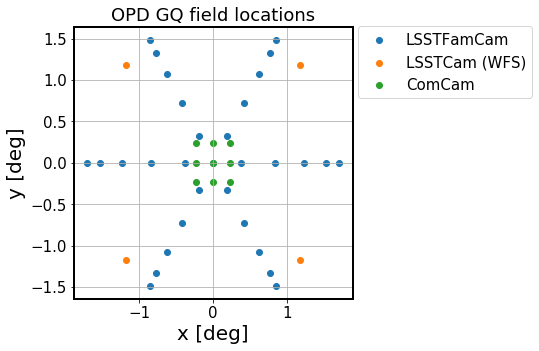

In [121]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(fieldX, fieldY, label='LSSTFamCam')
ax.scatter(fieldWFSx, fieldWFSy, label='LSSTCam (WFS)')
ax.scatter(fieldComCamX,fieldComCamY, label='ComCam')
ax.legend(bbox_to_anchor=(1.67, 1.03))
ax.set_xlabel('x [deg]')
ax.set_ylabel('y [deg]')
ax.set_title('OPD GQ field locations')
ax.grid()

In [91]:
# show that this is indeed how the gq_eff_pssn  and gq_eff_fwhm  are 
# evaluated for LsstFamCam :
accessPath = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs'
opdDir = os.path.join(accessPath, 'arrowStars','iter0','img')
pssn = np.loadtxt(os.path.join(opdDir, 'PSSN.txt'))

The same file structure as for ComCam, but with 31 field locations: 

In [92]:
# the first row contains PSSN evaluated at chosen field locations:
# 9 for comcam 
first_row = pssn[0]
# all but the last value are the PSSN 
pssn_values  = first_row[:-1]
print(len(pssn_values))
# the last value is the GQ effective PSSN : the 
# weighted sum of the PSSN with weights corresponding to hte 
# Gaussian Quadrature locations 
gq_eff_pssn = first_row[-1]

31


And we can show that using the normalized weighting ratio for the 31 field locations we arrive at the 
`GQ_EFF_PSSN` or `GQ_EFF_FWHM` : 

In [93]:
gq_eff_pssn_calc = np.sum(lsstFamCamWtRatioNormed*pssn_values)
print(gq_eff_pssn, gq_eff_pssn_calc)

0.6021930567814272 0.6021930567814272
